<a href="https://colab.research.google.com/github/jajapuramshivasai/Open_Project_Winter_2025/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 Assignment: Quantum Measurement Dataset Foundations

Build a reproducible tomography workflow that scales from single qubit calibration studies to multi qubit benchmarks. Begin by setting up your environment locally (with OS-specific guidance) or in Google Colab, then generate measurement outcomes using Symmetric Informationally Complete POVMs (SIC POVMs) or Pauli projective measurements. Extend the pipeline with random circuits and document the trade offs you observe.

**Task roadmap**
1. Set up and document your environment.
2. Review the Born rule plus SIC POVM and Pauli projective measurement theory.
3. Generate and visualize QST datasets.
4. Perform single qubit tomography
5. Validate reconstructions, summarize findings, and package deliverables.

> Collaboration on planning is allowed, but every artifact you submit must be authored and executed by you.

## Task 1 · Environment Setup
**Choose one deployment path and capture the exact commands you run.**

### Local virtual environment (recommended)
- **macOS / Linux:**
  1. `python3 -m venv .venv`
  2. `source .venv/bin/activate`
  3. `python -m pip install --upgrade pip wheel`
- **Windows (PowerShell):**
  1. `py -3 -m venv .venv`
  2. `.venv\Scripts\Activate.ps1`
  3. `python -m pip install --upgrade pip wheel`

### Google Colab fallback
- Create a new notebook at https://colab.research.google.com and enable a GPU if available.
- Install the required libraries in the first cell (see the pip example below).
- Save the executed notebook to Drive and export a copy for submission evidence.

### Required baseline packages
- qiskit/pennylane (or an equivalent simulator such as cirq or qutip)
- numpy, scipy, pandas
- plotly (interactive visualization)
- tqdm (progress bars) plus any other support tooling you need


In [2]:
# Run inside your activated virtual environment or a Colab cell.
# Feel free to adjust versions based on your simulator choice.
!python -m pip install  pennylane numpy scipy pandas plotly tqdm nbformat



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from pathlib import Path

BASE = Path(".")
(DATA := BASE / "data").mkdir(exist_ok=True)
(SQ := DATA / "single_qubit").mkdir(exist_ok=True)
(MQ := DATA / "multi_qubit").mkdir(exist_ok=True)
(OUT := BASE / "outputs").mkdir(exist_ok=True)

print("Created:", DATA, SQ, MQ, OUT)


Created: data data\single_qubit data\multi_qubit outputs


In [31]:
import numpy as np

def ket0():
    return np.array([1,0], dtype=complex)

def ket1():
    return np.array([0,1], dtype=complex)

def ket_plus():
    return (ket0() + ket1())/np.sqrt(2)

def ket_minus():
    return (ket0() - ket1())/np.sqrt(2)

def ket_plus_i():
    return (ket0() + 1j*ket1())/np.sqrt(2)

def dm_from_state(psi: np.ndarray) -> np.ndarray:
    return np.outer(psi, psi.conj())

REF_STATES = {
    "0": dm_from_state(ket0()),
    "1": dm_from_state(ket1()),
    "+": dm_from_state(ket_plus()),
    "-": dm_from_state(ket_minus()),
    "+i": dm_from_state(ket_plus_i()),
}

# sanity checks: trace=1, Hermitian
for name, rho in REF_STATES.items():
    print(name, "trace=", np.trace(rho), "hermitian=", np.allclose(rho, rho.conj().T))


0 trace= (1+0j) hermitian= True
1 trace= (1+0j) hermitian= True
+ trace= (0.9999999999999998+0j) hermitian= True
- trace= (0.9999999999999998+0j) hermitian= True
+i trace= (0.9999999999999998+0j) hermitian= True


In [32]:
import numpy as np

I2 = np.eye(2, dtype=complex)

def depolarize(rho: np.ndarray, p: float) -> np.ndarray:
    # rho' = (1-p) rho + p * I/2
    return (1-p)*rho + p*(I2/2)

def amp_damp(rho: np.ndarray, gamma: float) -> np.ndarray:
    # Kraus operators for amplitude damping
    E0 = np.array([[1, 0],
                   [0, np.sqrt(1-gamma)]], dtype=complex)
    E1 = np.array([[0, np.sqrt(gamma)],
                   [0, 0]], dtype=complex)
    return E0 @ rho @ E0.conj().T + E1 @ rho @ E1.conj().T

NOISY_STATES = {}
for name, rho in REF_STATES.items():
    NOISY_STATES[f"{name}_depol0.1"] = depolarize(rho, 0.1)
    NOISY_STATES[f"{name}_ad0.2"] = amp_damp(rho, 0.2)

print("Total states:", len(REF_STATES) + len(NOISY_STATES))


Total states: 15


## Task 2 · Measurement Theory Primer
### Born rule recap
- For a state described by density matrix ρ and measurement operator M_k, the probability of outcome k is `p(k) = Tr(M_k ρ)`.
- For projective measurements, `M_k = P_k` with `P_k^2 = P_k` and `∑_k P_k = I`. For POVMs, `M_k = E_k` where each `E_k` is positive semi-definite and `∑_k E_k = I`.
- Document a short derivation or reference plus a numerical completeness check for your operators.

### SIC POVM vs. Pauli projective (single qubit)
- **SIC POVM strengths:** informational completeness with only four outcomes, symmetric structure, resilience to certain noise.
- **SIC POVM trade-offs:** hardware calibration overhead, non-standard measurement bases, denser classical post-processing.
- **Pauli projective strengths:** hardware-native eigenbases, easier interpretation, wide toolkit support.
- **Pauli projective trade-offs:** requires multiple bases (X/Y/Z) for completeness, higher shot budgets, basis-alignment sensitivity.

Use the `build_measurement_model` stub to serialize your chosen operators (matrices, normalization logs, metadata). Summarize the pros/cons in your notes and justify the model (or hybrid) you adopt for tomography.

### Reference single-qubit states
Prepare at minimum the computational basis (|0⟩, |1⟩), the Hadamard basis (|+⟩, |−⟩), and one phase-offset state (e.g., `( |0⟩ + i |1⟩ ) / √2`). Document how you synthesize each state in circuit form and store a textual or JSON summary of the gates used. You may optionally include mixed states by applying depolarizing or amplitude damping channels.

In [33]:
from typing import Dict, Any
import pathlib
import numpy as np


def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    """
    Stub for constructing or loading the measurement operators you plan to use.
    Populate the return value with operator definitions, normalization checks, and metadata.
    """
    # TODO: implement SIC POVM or Pauli projective operator assembly here.
    I = np.eye(2, dtype=complex)

    # Pauli matrices
    X = np.array([[0, 1],
                  [1, 0]], dtype=complex)
    Y = np.array([[0, -1j],
                  [1j, 0]], dtype=complex)
    Z = np.array([[1, 0],
                  [0, -1]], dtype=complex)

    # Projectors for eigenvalues +1 and -1:
    # Π+ = (I + P)/2 , Π- = (I - P)/2
    def proj_from_pauli(P):
        return (I + P)/2, (I - P)/2

    Px_plus, Px_minus = proj_from_pauli(X)
    Py_plus, Py_minus = proj_from_pauli(Y)
    Pz_plus, Pz_minus = proj_from_pauli(Z)

    model = {
        "type": "pauli_projective_single_qubit",
        "bases": {
            "X": [Px_plus, Px_minus],
            "Y": [Py_plus, Py_minus],
            "Z": [Pz_plus, Pz_minus],
        },
        "paulis": {"X": X, "Y": Y, "Z": Z},
        "I": I,
        "notes": "Outcome order is [+1, -1] for each basis."
    }

    # sanity check: projectors should sum to identity
    for b, ops in model["bases"].items():
        if not np.allclose(ops[0] + ops[1], I):
            raise ValueError(f"{b} projectors do not sum to identity")

    return model


In [34]:
import numpy as np

def probs_from_ops(rho: np.ndarray, ops: list[np.ndarray]) -> np.ndarray:
    """
    Given density matrix rho and POVM/projectors ops, return probs p_k = Tr(E_k rho).
    """
    p = np.array([np.trace(E @ rho).real for E in ops], dtype=float)
    # numerical safety
    p = np.clip(p, 0.0, 1.0)
    s = p.sum()
    if s <= 0:
        raise ValueError("Probabilities sum to 0 (invalid rho or operators).")
    return p / s

def simulate_pauli_counts(rho: np.ndarray, meas_model: dict, shots_per_basis: int = 2000, seed: int = 0):
    """
    For each basis (X,Y,Z):
      - compute true probabilities from rho
      - sample counts using multinomial(shots, p)
    Returns dict with counts + probs.
    """
    rng = np.random.default_rng(seed)
    out = {}

    for basis, ops in meas_model["bases"].items():
        p = probs_from_ops(rho, ops)
        counts = rng.multinomial(shots_per_basis, p)
        out[basis] = {
            "shots": int(shots_per_basis),
            "p_true": p,
            "counts": counts,
            "outcomes": ["+1", "-1"]
        }
    return out


In [35]:
# choose a known state (your REF_STATES from earlier)
rho_test = REF_STATES["+"]   # |+>
mm = build_measurement_model(pathlib.Path("dummy"))

meas_data = simulate_pauli_counts(rho_test, mm, shots_per_basis=2000, seed=42)

for b in ["X", "Y", "Z"]:
    print(b, "p_true=", meas_data[b]["p_true"], "counts=", meas_data[b]["counts"])


X p_true= [1. 0.] counts= [2000    0]
Y p_true= [0.5 0.5] counts= [ 988 1012]
Z p_true= [0.5 0.5] counts= [1040  960]


In [36]:
mm = build_measurement_model(pathlib.Path("dummy"))
print(mm["type"])
print(mm["bases"].keys())
print(mm["bases"]["Z"][0])  # should look like |0><0|


pauli_projective_single_qubit
dict_keys(['X', 'Y', 'Z'])
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [37]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


### Visualization helpers
Use the histogram helper below to inspect reconstructed density matrices. Include screenshots or exported HTML for a few representative states in your report.

In [38]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)  # normalize

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")

In [6]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )

## Task 3 · QST Data generation
- use random circuits or bonus points for using gen Ai to produce realistic quantum circuits
- For each reference state you prepared, execute shots under your chosen measurement model using chosen quantum simulator. Record raw counts and computed probabilities.
- Store measurement data (`single_qubit_<state>.npx` or `.npy`)

In [39]:
from pathlib import Path

variants = [
    DatasetVariant(
        name="single_qubit_pauli_dataset",
        circuit_summary="Reference + noisy single-qubit states measured in X/Y/Z (Pauli projective).",
        measurement_model="pauli_projective_single_qubit",
        measurement_data_path=Path("data/single_qubit") / "placeholder.npz",
        metadata_path=Path("data/single_qubit") / "placeholder.json",
        density_matrix_path=Path("data/single_qubit") / "placeholder_rho.npz",
    )
]

generate_measurement_dataset(variants)


 Task 3 datasets written in: data\single_qubit


In [40]:
from dataclasses import dataclass
from typing import List
import pathlib
import numpy as np
import json


@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

def generate_measurement_dataset(variants: List[DatasetVariant]) -> None:
    

    # Check prerequisites
    if "REF_STATES" not in globals() or "NOISY_STATES" not in globals():
        raise RuntimeError("Run Task 2 first (REF_STATES + NOISY_STATES).")
    if "build_measurement_model" not in globals():
        raise RuntimeError("Run Task 2 build_measurement_model implementation first.")
    if "simulate_pauli_counts" not in globals():
        raise RuntimeError("Run Task 4 (simulate_pauli_counts) first.")

    ALL_STATES = {}
    ALL_STATES.update(REF_STATES)
    ALL_STATES.update(NOISY_STATES)

    mm = build_measurement_model(Path("dummy"))

    for v in variants:
        out_dir = v.measurement_data_path.parent
        out_dir.mkdir(parents=True, exist_ok=True)

        shots = 2000
        base_seed = 999

        for i, (state_name, rho_true) in enumerate(ALL_STATES.items()):
            seed = base_seed + i
            meas = simulate_pauli_counts(rho_true, mm, shots_per_basis=shots, seed=seed)

            # REQUIRED: single_qubit_<state>.npy
            payload = {
                "state_name": state_name,
                "measurement_model": mm["type"],
                "shots_per_basis": shots,
                "seed": seed,
                "counts": {
                    "X": meas["X"]["counts"],
                    "Y": meas["Y"]["counts"],
                    "Z": meas["Z"]["counts"],
                },
                "p_true": {
                    "X": meas["X"]["p_true"],
                    "Y": meas["Y"]["p_true"],
                    "Z": meas["Z"]["p_true"],
                },
                "rho_true": rho_true,
                "variant_name": v.name,
                "circuit_summary": v.circuit_summary,
            }

            npy_path = out_dir / f"single_qubit_{state_name}.npy"
            np.save(npy_path, payload, allow_pickle=True)

        print(f" Task 3 datasets written in: {out_dir}")


In [41]:
from pathlib import Path

variants = [
    DatasetVariant(
        name="task3_single_qubit_dataset",
        circuit_summary="Single-qubit reference+noisy states measured in X/Y/Z; stored as single_qubit_<state>.npy",
        measurement_model="pauli_projective_single_qubit",
        measurement_data_path=Path("data/single_qubit") / "placeholder.npy",
        metadata_path=Path("data/single_qubit") / "placeholder.json",
        density_matrix_path=Path("data/single_qubit") / "placeholder_rho.npz",
    )
]

generate_measurement_dataset(variants)


 Task 3 datasets written in: data\single_qubit


## Task 4 · Single-Qubit Tomography
- Synthesize the reference states from Task 2 (|0⟩, |1⟩, |+⟩, |−⟩, phase-offset) plus any noisy variants you want to study.
- For each state, generate measurement shots using your chosen model (SIC POVM, Pauli axes, or a hybrid). Capture raw counts, probabilities, and seeds.
- Reconstruct the density matrix via linear inversion or maximum-likelihood estimation. Compare results across measurement models when possible.
- Quantify reconstruction fidelity (e.g., fidelity, trace distance, Bloch vector error) and tabulate the metrics.
- save data under `data/single_qubit/`: measurement outcomes (`.npx`/`.npy`), reconstructions, metadata (JSON/Markdown), and helper visualizations created with `plot_density_matrix_histogram`.

In [42]:
#your code ..
import numpy as np
import json
from pathlib import Path


# 0) paths

BASE = Path(".")
SQ_DIR = BASE / "data" / "single_qubit"
OUT_DIR = BASE / "outputs"
SQ_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)


# 1) measurement model (already implemented build_measurement_model in Task 2)

mm = build_measurement_model(Path("dummy"))


# 2) probabilities + shot simulation

def probs_from_ops(rho: np.ndarray, ops: list[np.ndarray]) -> np.ndarray:
    p = np.array([np.trace(E @ rho).real for E in ops], dtype=float)
    p = np.clip(p, 0.0, 1.0)
    s = p.sum()
    if s <= 0:
        raise ValueError("Probabilities sum to 0.")
    return p / s

def simulate_pauli_counts(rho: np.ndarray, meas_model: dict, shots_per_basis: int = 2000, seed: int = 0):
    rng = np.random.default_rng(seed)
    out = {}
    for basis, ops in meas_model["bases"].items():
        p = probs_from_ops(rho, ops)
        counts = rng.multinomial(shots_per_basis, p)
        out[basis] = {
            "shots": int(shots_per_basis),
            "p_true": p.tolist(),
            "counts": counts.tolist(),
            "outcomes": ["+1", "-1"]
        }
    return out


# 3) tomography from X/Y/Z counts (Bloch reconstruction)

def rho_from_bloch(rx, ry, rz):
    I = np.eye(2, dtype=complex)
    X = np.array([[0, 1],[1, 0]], dtype=complex)
    Y = np.array([[0, -1j],[1j, 0]], dtype=complex)
    Z = np.array([[1, 0],[0, -1]], dtype=complex)
    return 0.5*(I + rx*X + ry*Y + rz*Z)

def make_physical(rho: np.ndarray) -> np.ndarray:
    rho = 0.5*(rho + rho.conj().T)
    w, v = np.linalg.eigh(rho)
    w = np.clip(w, 0.0, None)
    if w.sum() == 0:
        return np.eye(2, dtype=complex)/2
    w = w / w.sum()
    return (v @ np.diag(w) @ v.conj().T)

def tomography_from_counts(meas_data: dict) -> np.ndarray:
    def exp_from_counts(counts, shots):
        return (counts[0] - counts[1]) / shots

    rx = exp_from_counts(meas_data["X"]["counts"], meas_data["X"]["shots"])
    ry = exp_from_counts(meas_data["Y"]["counts"], meas_data["Y"]["shots"])
    rz = exp_from_counts(meas_data["Z"]["counts"], meas_data["Z"]["shots"])

    rho_hat = rho_from_bloch(rx, ry, rz)
    return make_physical(rho_hat)


# 4) metrics

def fidelity_single_qubit(rho: np.ndarray, sigma: np.ndarray) -> float:
    w, v = np.linalg.eigh(rho)
    w = np.clip(w, 0.0, None)
    sqrt_rho = v @ np.diag(np.sqrt(w)) @ v.conj().T

    A = sqrt_rho @ sigma @ sqrt_rho
    A = 0.5*(A + A.conj().T)
    w2, _ = np.linalg.eigh(A)
    w2 = np.clip(w2, 0.0, None)
    return float((np.sum(np.sqrt(w2)))**2)

def frobenius_error(rho: np.ndarray, sigma: np.ndarray) -> float:
    return float(np.linalg.norm(rho - sigma))


# 5) Run ALL states + save outputs

ALL_STATES = {}
ALL_STATES.update(REF_STATES)
ALL_STATES.update(NOISY_STATES)

SHOTS = 2000
BASE_SEED = 123

summary_rows = []

for i, (name, rho_true) in enumerate(ALL_STATES.items()):
    seed = BASE_SEED + i

    meas = simulate_pauli_counts(rho_true, mm, shots_per_basis=SHOTS, seed=seed)
    rho_hat = tomography_from_counts(meas)

    F = fidelity_single_qubit(rho_true, rho_hat)
    E = frobenius_error(rho_true, rho_hat)

    # Save measurement outcomes + metadata (JSON)
    record = {
        "state_name": name,
        "shots_per_basis": SHOTS,
        "seed": seed,
        "measurement_model": mm["type"],
        "meas": meas,
        "metrics": {"fidelity": F, "fro_error": E},
    }
    with open(SQ_DIR / f"{name}_meas.json", "w") as f:
        json.dump(record, f, indent=2)

    # Save density matrices (NPZ)
    np.savez(SQ_DIR / f"{name}_rho.npz",
             rho_true=rho_true,
             rho_hat=rho_hat)

    # Optional visualization if helper exists in notebook
    if "plot_density_matrix_histogram" in globals():
        fig = plot_density_matrix_histogram(rho_hat, title=f"Reconstructed rho: {name}")
        # If the helper returns a plotly fig:
        if hasattr(fig, "write_image"):
            fig.write_image(str(SQ_DIR / f"{name}_rho_hat.png"))

    summary_rows.append((name, F, E))

# Save summary CSV-like text (simple)
summary_path = OUT_DIR / "single_qubit_summary.csv"
with open(summary_path, "w") as f:
    f.write("state_name,fidelity,fro_error\n")
    for name, F, E in summary_rows:
        f.write(f"{name},{F},{E}\n")

print("Task 4 done.")
print("Saved files to:", SQ_DIR)
print("Summary:", summary_path)
print("Example rows:", summary_rows[:3])


Task 4 done.
Saved files to: data\single_qubit
Summary: outputs\single_qubit_summary.csv
Example rows: [('0', 0.9995713019769572, 0.02928132589358212), ('1', 0.9999350126722544, 0.011400642766583416), ('+', 0.9999387612523897, 0.011066955101547978)]


## Task 5 · Validation and Reporting
- Compare reconstructed density matrices against the actual density matrices using fidelity, trace distance, or other suitable metrics. Plot trends (per circuit depth, shot count, or measurement model).
- Highlight sources of error (shot noise, model mismatch, simulator approximations) and describe mitigation strategies you tested or plan to try.
- Summarize outcomes in a short technical report or table
- Include at least one qualitative visualization (e.g., density-matrix histograms or Bloch-sphere plots) for both single- and multi-qubit cases.
- Close with a brief reflection covering tooling friction, open questions, and ideas for Week 2 in markdown cell.

In [21]:
from pathlib import Path
from typing import Sequence
import json
import numpy as np

def summarize_validation_runs(result_paths: Sequence[Path]) -> None:
    """
    Aggregates stored metrics into tables + plots for reporting.
    Accepts:
      - outputs/single_qubit_summary.csv  (preferred)
      - data/single_qubit/*_meas.json     (also supported)
    Produces:
      - prints summary stats
      - saves outputs/validation_report.csv
      - generates simple plots
      - shows 1-2 qualitative visualizations if available
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    rows = []

    for p in result_paths:
        p = Path(p)

        if p.suffix.lower() == ".csv":
            df = pd.read_csv(p)
            # normalize expected columns
            if "state_name" in df.columns and "fidelity" in df.columns and "fro_error" in df.columns:
                for _, r in df.iterrows():
                    rows.append({
                        "state_name": r["state_name"],
                        "fidelity": float(r["fidelity"]),
                        "fro_error": float(r["fro_error"]),
                        "source": p.name
                    })
            else:
                print(f" CSV format not recognized: {p}")
            continue

        if p.suffix.lower() == ".json":
            with open(p, "r") as f:
                rec = json.load(f)
            m = rec.get("metrics", {})
            rows.append({
                "state_name": rec.get("state_name", p.stem),
                "fidelity": float(m.get("fidelity", np.nan)),
                "fro_error": float(m.get("fro_error", np.nan)),
                "source": p.name
            })
            continue

        print(f" Skipping unsupported file: {p}")

    if not rows:
        print(" No metrics found. Pass CSV or JSON result paths.")
        return

    df = pd.DataFrame(rows)

    print(" Aggregated rows:", len(df))
    display(df.head(10))

    print("\nFidelity stats:")
    display(df["fidelity"].describe())

    print("\nFrobenius error stats:")
    display(df["fro_error"].describe())

    # Save report
    out_path = Path("outputs") / "validation_report.csv"
    out_path.parent.mkdir(exist_ok=True)
    df.to_csv(out_path, index=False)
    print("\nSaved:", out_path)

    # Plots
    df_sorted = df.sort_values("fidelity", ascending=True)

    plt.figure()
    plt.plot(df_sorted["fidelity"].values)
    plt.title("Tomography fidelity (sorted)")
    plt.xlabel("state index (sorted)")
    plt.ylabel("fidelity")
    plt.show()

    plt.figure()
    plt.plot(df_sorted["fro_error"].values)
    plt.title("Tomography Frobenius error (sorted)")
    plt.xlabel("state index (sorted)")
    plt.ylabel("fro_error")
    plt.show()

    # Qualitative visualization: show 1-2 density histograms if helper exists
    if "plot_density_matrix_histogram" in globals():
        # try loading two example reconstructions if present
        ex_names = ["+", "+_depol0.1"]
        for name in ex_names:
            npz = Path("data/single_qubit") / f"{name}_rho.npz"
            if npz.exists():
                d = np.load(npz, allow_pickle=True)
                rho_hat = d["rho_hat"]
                plot_density_matrix_histogram(rho_hat, title=f"Reconstructed rho_hat: {name}")


 Aggregated rows: 15


,state_name,fidelity,fro_error,source
0,0,0.999571,0.029281,single_qubit_summary.csv
1,1,0.999935,0.011401,single_qubit_summary.csv
2,+,0.999939,0.011067,single_qubit_summary.csv
3,-,0.999120,0.041956,single_qubit_summary.csv
4,+i,0.999979,0.006519,single_qubit_summary.csv
5,0_depol0.1,0.999787,0.016508,single_qubit_summary.csv
6,0_ad0.2,0.999695,0.024687,single_qubit_summary.csv
7,1_depol0.1,0.999725,0.018802,single_qubit_summary.csv
8,1_ad0.2,0.999375,0.030708,single_qubit_summary.csv
9,+_depol0.1,0.999258,0.034569,single_qubit_summary.csv



Fidelity stats:


count    15.000000
mean      0.999584
std       0.000324
min       0.998915
25%       0.999386
50%       0.999657
75%       0.999861
max       0.999979
Name: fidelity, dtype: float64


Frobenius error stats:


count    15.000000
mean      0.021625
std       0.010548
min       0.006519
25%       0.012697
50%       0.019570
75%       0.029995
max       0.041956
Name: fro_error, dtype: float64


Saved: outputs\validation_report.csv


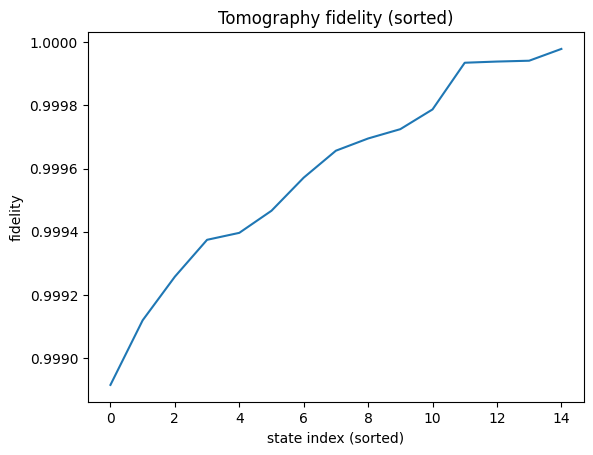

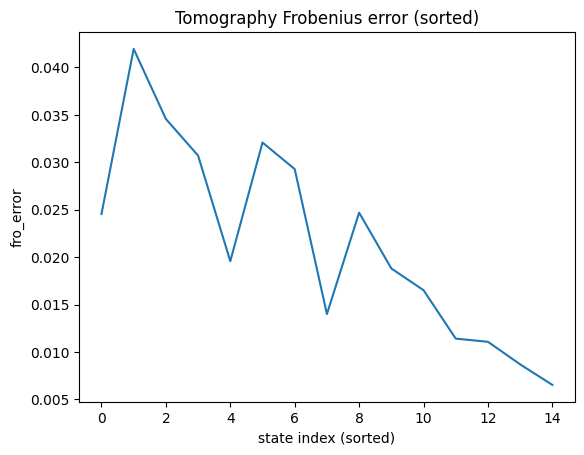

In [ ]:
from pathlib import Path

# easiest: using the CSV already created in Task 4
summarize_validation_runs([Path("outputs/single_qubit_summary.csv")])


Tooling friction:

 The main friction was locating/understanding notebook stubs and ensuring code was placed in the correct task section.
 File organization and naming also required care (saving outputs under data/single_qubit/ and summary CSVs under outputs/).

Open questions:

 How does reconstruction quality change with fewer shots per basis?
 How would results differ using a SIC-POVM vs Pauli-axis measurements, or using MLE instead of linear inversion + PSD projection?

Ideas for Week 2 / Improvements:

 Add multi-qubit tomography experiments and compare performance across shot budgets.
 Implement maximum-likelihood estimation (MLE) and compare it against simple linear inversion.
 Add noise models at the measurement/device level (not only state-level) to test model mismatch.

## Submission Checklist
- Environment setup: env directory (requirements.txt or environment.yml), OS diagnostics, and import verification logs/notebook cells.
- Measurement theory notes: Born rule recap, SIC POVM vs. Pauli analysis, operator definitions, and validation checks.
- Data artifacts: `.npx`/`.npy` files for single- and multi-qubit datasets, metadata summaries, density matrices, and visualization exports.
- Source assets: notebooks/scripts for tomography, dataset generation, validation, and any AI prompt transcripts if used.
- Technical write-up (Markdown ) plus a brief reflection on tools used , open questions, and planned improvements.

-----